In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, VecToScalarFeed, gen_added_strings, meg_from_spikes
from nengo_learn_assoc_mem.meg_ia import MegAssociativeMemory

In [13]:
from collections import namedtuple, OrderedDict

In [3]:
D = 32
seed = 8

t_present = 0.3
t_pause = 0.5
t_each = t_present + t_pause

integ_tau = 0.1
n_pairs = 16

dt = 0.001

In [6]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, \
    foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_pairs, n_pairs, D, seed, norm=True)

all_fan = fan1 + fan2
all_fan_pairs = gen_added_strings(all_fan)

all_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

target_ans = [1] * (len(fan1) + len(fan2))
foil_ans = [-1] * (len(foil1) + len(foil2))
all_ans = target_ans + foil_ans

In [7]:
n_accum_neurons = [45] * len(fan1) + [40] * len(fan2)
n_thresh_neurons = [15] * len(all_fan)

In [8]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+int(t_each/dt)*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+int(t_each/dt)*len(foil2_pair_vecs))

In [9]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, fan1_slc),
                 "fan2": SlcStim(2, True, fan2_slc),
                 "foil1": SlcStim(1, False, foil1_slc),
                 "foil2": SlcStim(2, False, foil2_slc)}

In [14]:
feed = VecToScalarFeed(all_vecs, all_ans, t_present, t_pause)

with spa.Network("Associative Model", seed=seed) as model:
    model.famili = nengo.Node(feed.feed)
    model.correct = nengo.Node(feed.get_answer)
    model.reset = nengo.Node(lambda t: feed.paused)

    model.cleanup = MegAssociativeMemory(n_accum_neurons=n_accum_neurons,
                                         n_thresholding_neurons=n_thresh_neurons,
                                         input_vocab=vocab,
                                         mapping=OrderedDict(zip(all_fan_pairs, all_fan_pairs)))

    nengo.Connection(model.famili, model.cleanup.input, synapse=None)
    nengo.Connection(model.reset, model.cleanup.input_reset, synapse=None)

    p_in = nengo.Probe(model.famili, synapse=None, label="input")
    p_clean = nengo.Probe(model.cleanup.output, synapse=0.01, label="clean")
    p_cor = nengo.Probe(model.correct, synapse=None, label="correct")

    p_spikes = []

    for am_ens in model.cleanup.selection.accumulators.thresholding.ea_ensembles:
        p_spikes.append(nengo.Probe(am_ens.neurons))

In [15]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(len(all_vecs)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:01:09.                                                                              


## Plot MEG data

In [16]:
t_range = sim.trange()
all_meg = np.sum(np.array([meg_from_spikes(sim.data[p_spk]) for p_spk in p_spikes]), axis=0)

In [17]:
df_list = []

for s_t in slc_stim_vecs.values():
    act = all_meg[s_t.slc]
    tt = [s_t.targ] * len(act)
    rr = [s_t.fan_num] * len(act)
    df_list.append(pd.DataFrame({"act": act, "targ": tt, "resp": rr}))

act_df = pd.concat(df_list)

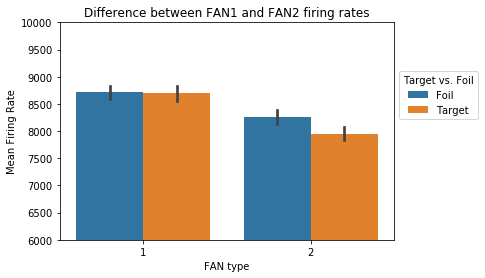

In [53]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)
ax.set_ylim((6000, 10000))

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
ax.legend_.set_bbox_to_anchor((1, 0.8))
new_labels = ("Foil", "Target")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

## Plot decoded results

### Output decoded properly for Targets

In [21]:
fan1_labels = gen_added_strings(fan1)

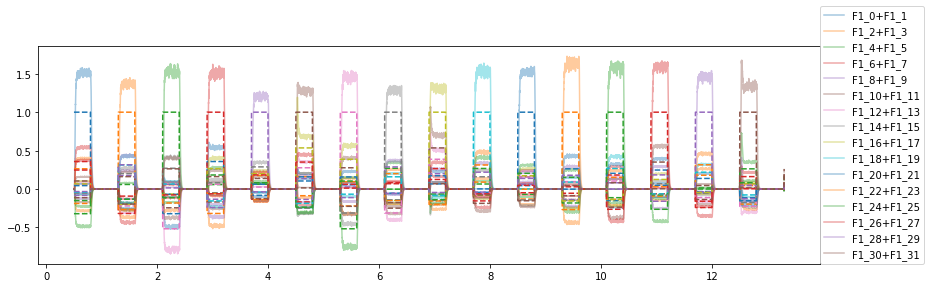

In [30]:
plt.figure(figsize=(14, 4))
plt.plot(t_range[fan1_slc], spa.similarity(sim.data[p_clean][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(t_range[fan1_slc], spa.similarity(sim.data[p_in][fan1_slc], fan1_pair_vecs), linestyle='--')
plt.legend(fan1_labels, loc=(1, 0))

### Foils are mapped back onto targets

In [31]:
foil1_labels = gen_added_strings(foil1)

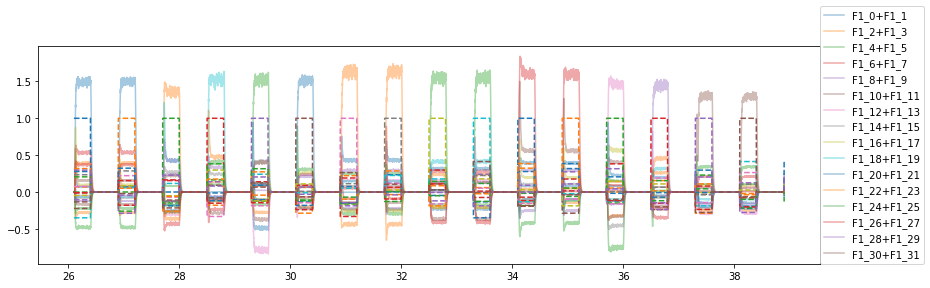

In [34]:
plt.figure(figsize=(14, 4))
plt.plot(t_range[foil1_slc], spa.similarity(sim.data[p_clean][foil1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(t_range[foil1_slc], spa.similarity(sim.data[p_in][foil1_slc], foil1_pair_vecs), linestyle='--')
plt.legend(fan1_labels, loc=(1, 0))